In [109]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','META','NVDA']
tickers_2 = ['SPY','AGG','GLD','TLT','VNQ']
tickers_3 = ['SPY','EWJ','INDA','EWU','EZA'] # 5 country ETFs, non-overlapping
start_date = '2019-01-01'
end_date = '2025-06-30'

In [111]:
data = yf.download(tickers_3, start=start_date, end=end_date)['Close']
print(data.head())

/var/folders/v6/hggmpf4134v8nppmrh142shw0000gn/T/ipykernel_4136/245959217.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers_3, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed

Ticker            EWJ        EWU        EZA       INDA         SPY
Date                                                              
2019-01-02  45.413990  22.889402  35.622135  30.244143  225.660156
2019-01-03  45.155952  22.748930  35.728378  29.628977  220.275314
2019-01-04  46.686356  23.381063  37.676300  30.574682  227.653580
2019-01-07  46.802029  23.381063  37.187553  30.133963  229.448502
2019-01-08  47.024467  23.521538  37.201714  30.225780  231.604248


In [112]:
def calculate_returns(prices, method='log'):
    if method == 'simple':
        returns = prices.pct_change().dropna()
    elif method == 'log':
        returns = np.log(prices / prices.shift(1)).dropna()
    
    return returns

In [113]:
log_returns = calculate_returns(data, method='log')
print(log_returns.head())

Ticker           EWJ       EWU       EZA      INDA       SPY
Date                                                        
2019-01-03 -0.005698 -0.006156  0.002978 -0.020550 -0.024152
2019-01-04  0.033330  0.027408  0.053086  0.031419  0.032947
2019-01-07  0.002475  0.000000 -0.013057 -0.014519  0.007854
2019-01-08  0.004742  0.005990  0.000381  0.003042  0.009351
2019-01-09  0.005472  0.009576  0.025380  0.000000  0.004663


In [ ]:
simple_cov = log_returns.cov()*252
print(simple_cov)

Ticker       EWJ       EWU       EZA      INDA       SPY
Ticker                                                  
EWJ     0.033866  0.028071  0.036633  0.024903  0.028407
EWU     0.028071  0.042764  0.047901  0.032131  0.032903
EZA     0.036633  0.047901  0.098941  0.045588  0.041838
INDA    0.024903  0.032131  0.045588  0.053545  0.031044
SPY     0.028407  0.032903  0.041838  0.031044  0.041506


In [115]:
def get_ledoit_wolf_covariance(returns):
    lw = LedoitWolf()
    lw.fit(returns)
    
    cov_lw = lw.covariance_ * 252
    
    cov_df = pd.DataFrame(
        cov_lw, 
        index=returns.columns, 
        columns=returns.columns
    )
    return cov_df

In [116]:
lw_cov = get_ledoit_wolf_covariance(log_returns)
print(lw_cov)

Ticker       EWJ       EWU       EZA      INDA       SPY
Ticker                                                  
EWJ     0.034254  0.027487  0.035871  0.024386  0.027816
EWU     0.027487  0.042967  0.046905  0.031463  0.032218
EZA     0.035871  0.046905  0.097976  0.044640  0.040968
INDA    0.024386  0.031463  0.044640  0.053524  0.030398
SPY     0.027816  0.032218  0.040968  0.030398  0.041735


In [117]:
def compare_matrices(cov_sample, cov_lw):

    def to_corr(cov):
        v = np.sqrt(np.diag(cov))
        outer_v = np.outer(v, v)
        corr = cov / outer_v
        corr[cov == 0] = 0
        return corr

    corr_sample = to_corr(cov_sample)
    corr_lw = to_corr(cov_lw)
    
    diff = corr_sample - corr_lw
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.heatmap(corr_sample, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
    axes[0].set_title("Sample Correlation (Noisy)")
    
    sns.heatmap(corr_lw, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
    axes[1].set_title("Ledoit-Wolf (Shrinkage)")
    
    sns.heatmap(diff, ax=axes[2], cmap='bwr', center=0)
    axes[2].set_title("Difference (Sample - LW)\nWhat was removed?")
    
    plt.tight_layout()
    plt.show()

    cond_sample = np.linalg.cond(cov_sample)
    cond_lw = np.linalg.cond(cov_lw)
    
    print(f"Condition Number (Sample): {cond_sample:,.2f}")
    print(f"Condition Number (Ledoit-Wolf): {cond_lw:,.2f}")
    print(f"Improvement: {(cond_sample - cond_lw)/cond_sample:.1%} more stable")

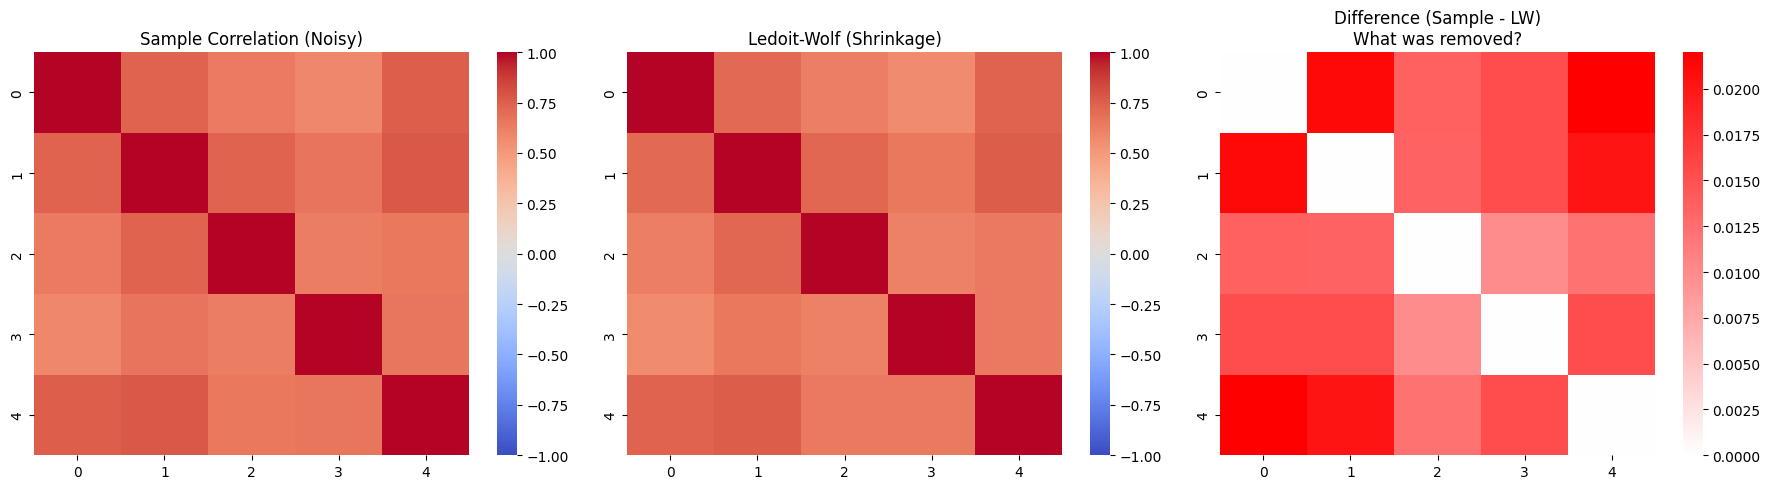

Condition Number (Sample): 23.73
Condition Number (Ledoit-Wolf): 21.12
Improvement: 11.0% more stable


In [118]:
compare_matrices(simple_cov.values, lw_cov.values)

In [ ]:
def plot_covid_stress_test(returns):
    """
    Compares correlations during a Calm Period vs. COVID Crash.
    """
    calm_start, calm_end = '2019-01-01', '2019-12-31'
    covid_start, covid_end = '2020-02-15', '2020-04-15' 
    
    if not np.issubdtype(returns.index.dtype, np.datetime64):
         returns.index = pd.to_datetime(returns.index)

    rets_calm = returns.loc[calm_start:calm_end]
    rets_covid = returns.loc[covid_start:covid_end]
    
    corr_calm = rets_calm.corr()
    corr_covid = rets_covid.corr()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.heatmap(corr_calm, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1, annot=True)
    axes[0].set_title(f"Calm Market ({calm_start[:4]})")
    
    sns.heatmap(corr_covid, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1, annot=True)
    axes[1].set_title("COVID Panic (Feb-Apr 2020)\nNotice the correlations turning positive!")
    
    plt.tight_layout()
    plt.show()

    avg_calm = corr_calm.values[np.triu_indices_from(corr_calm.values, 1)].mean()
    avg_covid = corr_covid.values[np.triu_indices_from(corr_covid.values, 1)].mean()
    
    print(f"Average Correlation (Calm): {avg_calm:.2f}")
    print(f"Average Correlation (COVID): {avg_covid:.2f}")

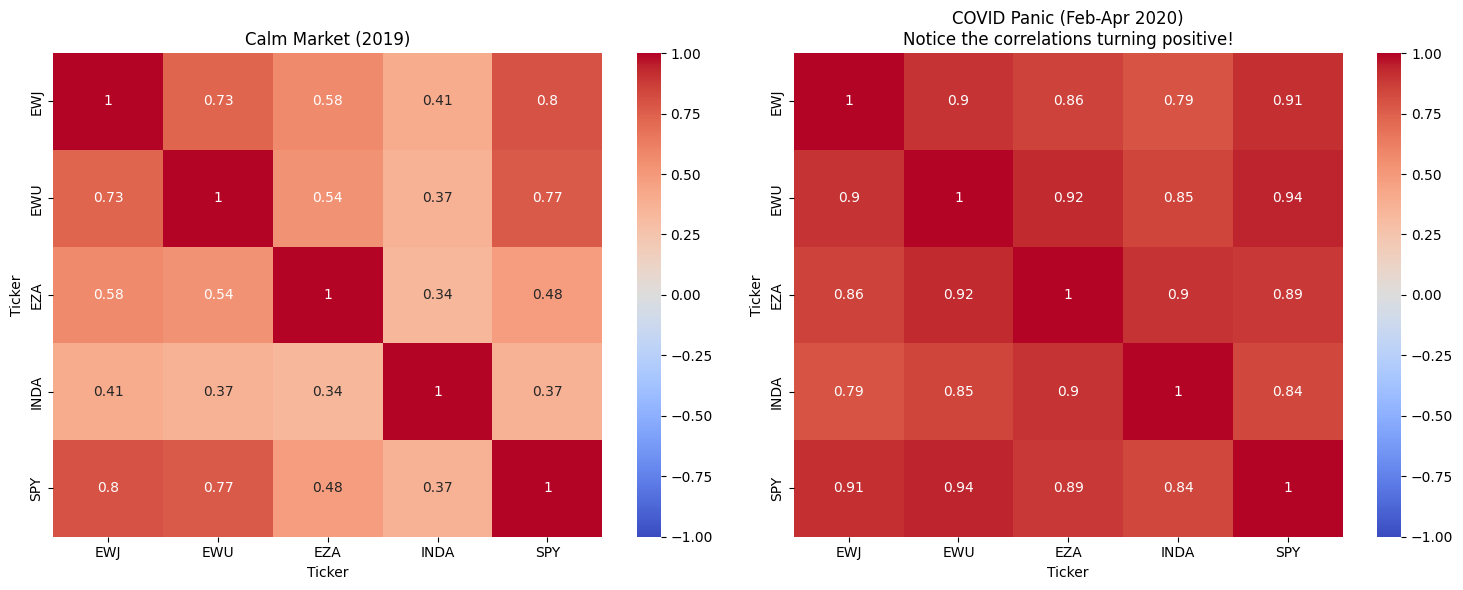

Average Correlation (Calm): 0.54
Average Correlation (COVID): 0.88


In [120]:
plot_covid_stress_test(log_returns)